In [1]:
!pip install --no-deps d2l

  Obtaining dependency information for d2l from https://files.pythonhosted.org/packages/8b/39/418ef003ed7ec0f2a071e24ec3f58c7b1f179ef44bec5224dcca276876e3/d2l-1.0.3-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 4.4 MB/s eta 0:00:00


In [2]:
import time
import torch
from torch import nn
from d2l import torch as d2l

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
torch.set_float32_matmul_precision("medium")

In [4]:
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

In [5]:
class Vgg(nn.Module):
    def __init__(self, conv_arch):
        super().__init__()
        conv_blks = []
        in_channels = 1
        for (num_convs, out_channels) in conv_arch:
            conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
            in_channels = out_channels
        self.features = nn.Sequential(*conv_blks)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(4096, 10))
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode="fan_in", nonlinearity="relu")
                nn.init.constant_(m.bias, 0)
    
    def forward(self, X):
        X = self.features(X)
        X = self.classifier(X)
        return X

In [6]:
conv_arch = {
    "11": ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512)),
    "13": ((2, 64), (2, 128), (2, 256), (2, 512), (2, 512)),
    "16": ((2, 64), (2, 128), (3, 256), (3, 512), (3, 512)),
    "19": ((2, 64), (2, 128), (4, 256), (4, 512), (4, 512)),
}

In [7]:
ratio = 4
small_conv_arch = {
  key: [(pair[0], pair[1] // ratio) for pair in value]
  for key, value in conv_arch.items()
}

In [8]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

100%|██████████| 26421880/26421880 [00:01<00:00, 13226765.87it/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 210337.34it/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3918155.71it/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 10905190.40it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



In [9]:
def train(net, train_iter, test_iter, num_epochs, lr, devices=d2l.try_all_gpus()):
    """Train a model with a GPU (defined in Chapter 6).

    Defined in :numref:`sec_utils`"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', str(devices))
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(devices[0]), y.to(devices[0])
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(devices)}')

训练 VGG-11

In [10]:
net = Vgg(small_conv_arch["11"])

loss 0.186, train acc 0.931, test acc 0.918
1040.3 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]
CPU times: user 10min 57s, sys: 1min 12s, total: 12min 10s
Wall time: 11min 30s


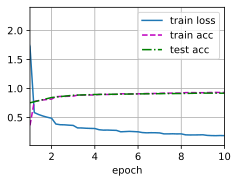

In [11]:
%%time
train(net, train_iter, test_iter, num_epochs, lr)

In [12]:
vgg11_path = "vgg11_epoch=10.pth"
vgg13_path = "vgg13_epoch=10.pth"
vgg16_path = "vgg16_epoch=10.pth"
vgg19_path = "vgg19_epoch=10.pth"

In [13]:
torch.save(net.state_dict(), vgg11_path)

训练 VGG13

In [14]:
net = Vgg(small_conv_arch["13"])
net.load_state_dict(torch.load(vgg11_path), strict=False)

_IncompatibleKeys(missing_keys=['features.0.2.weight', 'features.0.2.bias', 'features.1.2.weight', 'features.1.2.bias'], unexpected_keys=[])

loss 0.199, train acc 0.925, test acc 0.915
701.1 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]
CPU times: user 15min 52s, sys: 1min 11s, total: 17min 3s
Wall time: 16min 14s


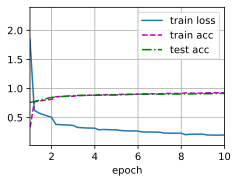

In [15]:
%%time
train(net, train_iter, test_iter, num_epochs, lr)

In [16]:
torch.save(net.state_dict(), vgg13_path)

训练 VGG-19

In [17]:
net = Vgg(small_conv_arch["16"])
net.load_state_dict(torch.load(vgg13_path), strict=False)

_IncompatibleKeys(missing_keys=['features.2.4.weight', 'features.2.4.bias', 'features.3.4.weight', 'features.3.4.bias', 'features.4.4.weight', 'features.4.4.bias'], unexpected_keys=[])

loss 0.210, train acc 0.923, test acc 0.913
632.3 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]
CPU times: user 17min 35s, sys: 1min 12s, total: 18min 47s
Wall time: 17min 53s


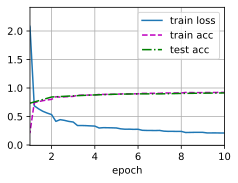

In [18]:
%%time
train(net, train_iter, test_iter, num_epochs, lr)

In [19]:
torch.save(net.state_dict(), vgg16_path)

In [20]:
net = Vgg(small_conv_arch["19"])
net.load_state_dict(torch.load(vgg16_path), strict=False)

_IncompatibleKeys(missing_keys=['features.2.6.weight', 'features.2.6.bias', 'features.3.6.weight', 'features.3.6.bias', 'features.4.6.weight', 'features.4.6.bias'], unexpected_keys=[])

loss 0.228, train acc 0.914, test acc 0.906
580.0 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]
CPU times: user 19min 9s, sys: 1min 12s, total: 20min 22s
Wall time: 19min 23s


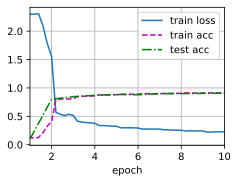

In [21]:
%%time
train(net, train_iter, test_iter, num_epochs, lr)

In [22]:
torch.save(net.state_dict(), vgg19_path)

In [23]:
from IPython.display import FileLink

In [24]:
FileLink(vgg13_path)

/kaggle/working/vgg13_epoch=10.pth

In [25]:
FileLink(vgg11_path)

/kaggle/working/vgg11_epoch=10.pth

In [26]:
FileLink(vgg16_path)

/kaggle/working/vgg16_epoch=10.pth

In [27]:
FileLink(vgg19_path)

/kaggle/working/vgg19_epoch=10.pth